In [2]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
positional <- read_tsv('/Users/hclimente/projects/waffles/results/fuma_mapping/physical_mapping.tsv') %>%
    group_by(ensg) %>%
    summarize(n = n()) %>%
    mutate(which = 'Positional')

eqtl <- read_tsv('/Users/hclimente/projects/waffles/results/fuma_mapping/eqtl_mapping.tsv') %>%
    group_by(ensg) %>%
    summarize(n = n()) %>%
    mutate(which = 'eQTL')

chromatin <- read_tsv('/Users/hclimente/projects/waffles/results/fuma_mapping/chromatin_interaction_mapping.tsv') %>%
    group_by(ensg) %>%
    summarize(n = n()) %>%
    mutate(which = 'Chromatin')


── Column specification ────────────────────────────────────────────────────────────────
cols(
  rsID = col_character(),
  ensg = col_character(),
  annot = col_character(),
  exonic_func = col_character()
)



── Column specification ────────────────────────────────────────────────────────────────
cols(
  rsID = col_character(),
  ensg = col_character(),
  tissue = col_character()
)



── Column specification ────────────────────────────────────────────────────────────────
cols(
  rsID = col_character(),
  ensg = col_character(),
  tissue = col_character(),
  where = col_character()
)




In [4]:
library(biomaRt)
ensembl_list <- c(positional$ensg, eqtl$ensg, chromatin$ensg) %>% unique
human <- useMart("ensembl", dataset="hsapiens_gene_ensembl")
gene_coords=getBM(attributes=c("hgnc_symbol","ensembl_gene_id", "start_position","end_position"), filters="ensembl_gene_id", values=ensembl_list, mart=human)
gene_coords$size=gene_coords$end_position - gene_coords$start_position
head(gene_coords)

,hgnc_symbol,ensembl_gene_id,start_position,end_position,size
,<chr>,<chr>,<int>,<int>,<int>
1,SCYL3,ENSG00000000457,169849631,169894267,44636
2,C1orf112,ENSG00000000460,169662007,169854080,192073
3,CFH,ENSG00000000971,196652043,196747504,95461
4,GCLC,ENSG00000001084,53497341,53616970,119629
5,NIPAL3,ENSG00000001461,24415802,24472976,57174
6,SEMA3F,ENSG00000001617,50155045,50189075,34030


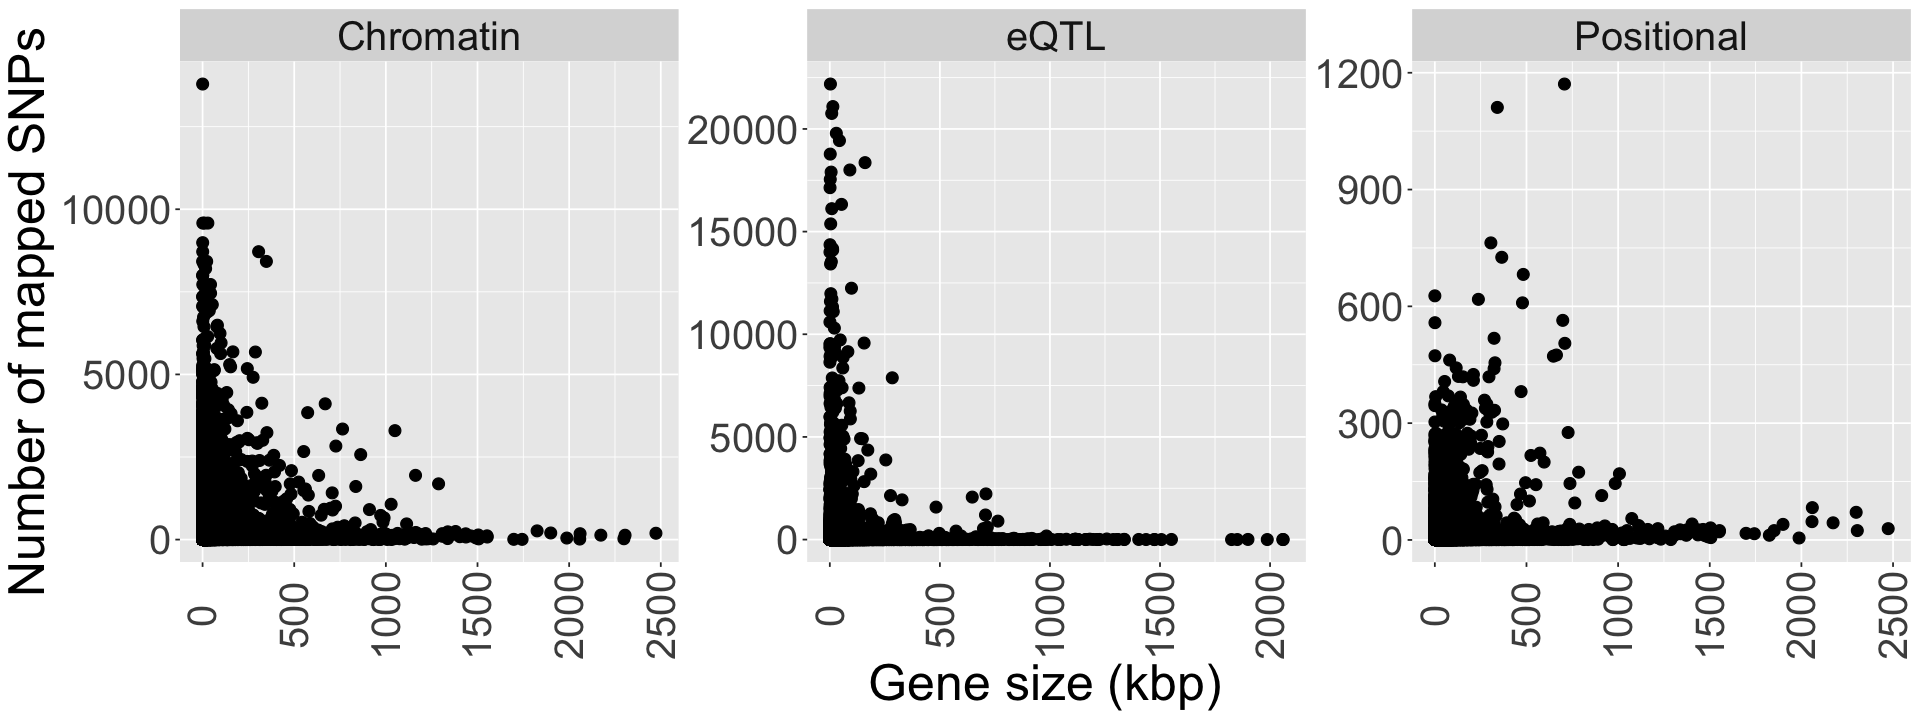

In [5]:
options(repr.plot.width=16, repr.plot.height=6)
bind_rows(
    inner_join(positional, gene_coords, by = c('ensg' = 'ensembl_gene_id')),
    inner_join(eqtl, gene_coords, by = c('ensg' = 'ensembl_gene_id')),
    inner_join(chromatin, gene_coords, by = c('ensg' = 'ensembl_gene_id'))
) %>%
    ggplot(aes(x = size/1000, y = n)) +
        geom_point(size = 3) +
        labs(x = 'Gene size (kbp)', y = 'Number of mapped SNPs') +
        facet_wrap(. ~ which, scales = 'free') + 
        theme(text = element_text(size = 30),
              axis.text.x = element_text(angle = 90, vjust = .5) )

In [6]:
library(igraph)
library(ggnetwork)
library(tidyverse)
library(cowplot)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA), # get rid of legend panel bg
                           strip.background = element_rect(fill="transparent", color = NA)
)

rslt <- '../results/'


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [12]:
plot_genes <- function(path, tag, color) {

    read_csv(paste0(rslt, path), col_types = 'ccdccc') %>%
    dplyr::select(SNP_1, SNP_2) %>%
    unique %>%
    graph_from_data_frame(directed = FALSE) %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray80') +
        geom_nodes(color = color) +
        geom_nodetext_repel(aes(label = name), size = 4.5) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        ggtitle(tag) + 
        theme(plot.title = element_text(size = 18, face = "bold", hjust = .5)) +
        theme_transparent

}

genes_chrom_pos <- plot_genes('withBiofilter_filter/chromatin_positional/sign_SNPpairs.txt', 'Positional + Chromatin', '#C6D57E')
genes_eqtl_pos <- plot_genes('withBiofilter_filter/eqtl_positional/sign_SNPpairs.txt', 'Positional + eQTL', '#63B4B8')

snp_plot <- plot_grid(plot_grid(genes_chrom_pos, genes_eqtl_pos))

In [13]:
plot_genes <- function(path, tag, color) {

    read_csv(paste0(rslt, path), col_types = 'cdccd') %>%
        separate(genePairs_names, into = c('gene_a', 'gene_b'), sep = ' ') %>%
        dplyr::select(gene_a, gene_b, MinP) %>%
        graph_from_data_frame(directed = FALSE) %>%
        ggnetwork %>%
        mutate(ibd = name %in% ibd_genes) %>%
        ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
            geom_edges(color = 'gray50', size = 3) +
            geom_nodes(aes(size = ibd, shape = ibd), color = color) +
            geom_nodetext_repel(aes(label = name), size = 5.5) +
            theme_blank() +
            theme(legend.position = 'none') +
            theme(plot.title = element_text(size = 18, face = "bold", hjust = .5)) +
            theme_transparent +
            ggtitle(tag) + 
            scale_size_manual(values = c('TRUE' = 13, 'FALSE' = 8)) +
            scale_shape_manual(values = c('TRUE' = 18, 'FALSE' = 16))

}

ibd_genes <- read_tsv('../data/C0021390_disease_gda_summary.tsv',
                      col_types = cols(.default = col_character()))$Gene

genes_chrom_pos <- plot_genes('withBiofilter_filter/chromatin_positional/sign_GenePairs.txt', 'Positional + Chromatin', '#C6D57E')
genes_eqtl_pos <- plot_genes('withBiofilter_filter/eqtl_positional/sign_GenePairs.txt', 'Positional + eQTL', '#63B4B8')


gene_plot <- plot_grid(plot_grid(genes_chrom_pos, genes_eqtl_pos))

Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


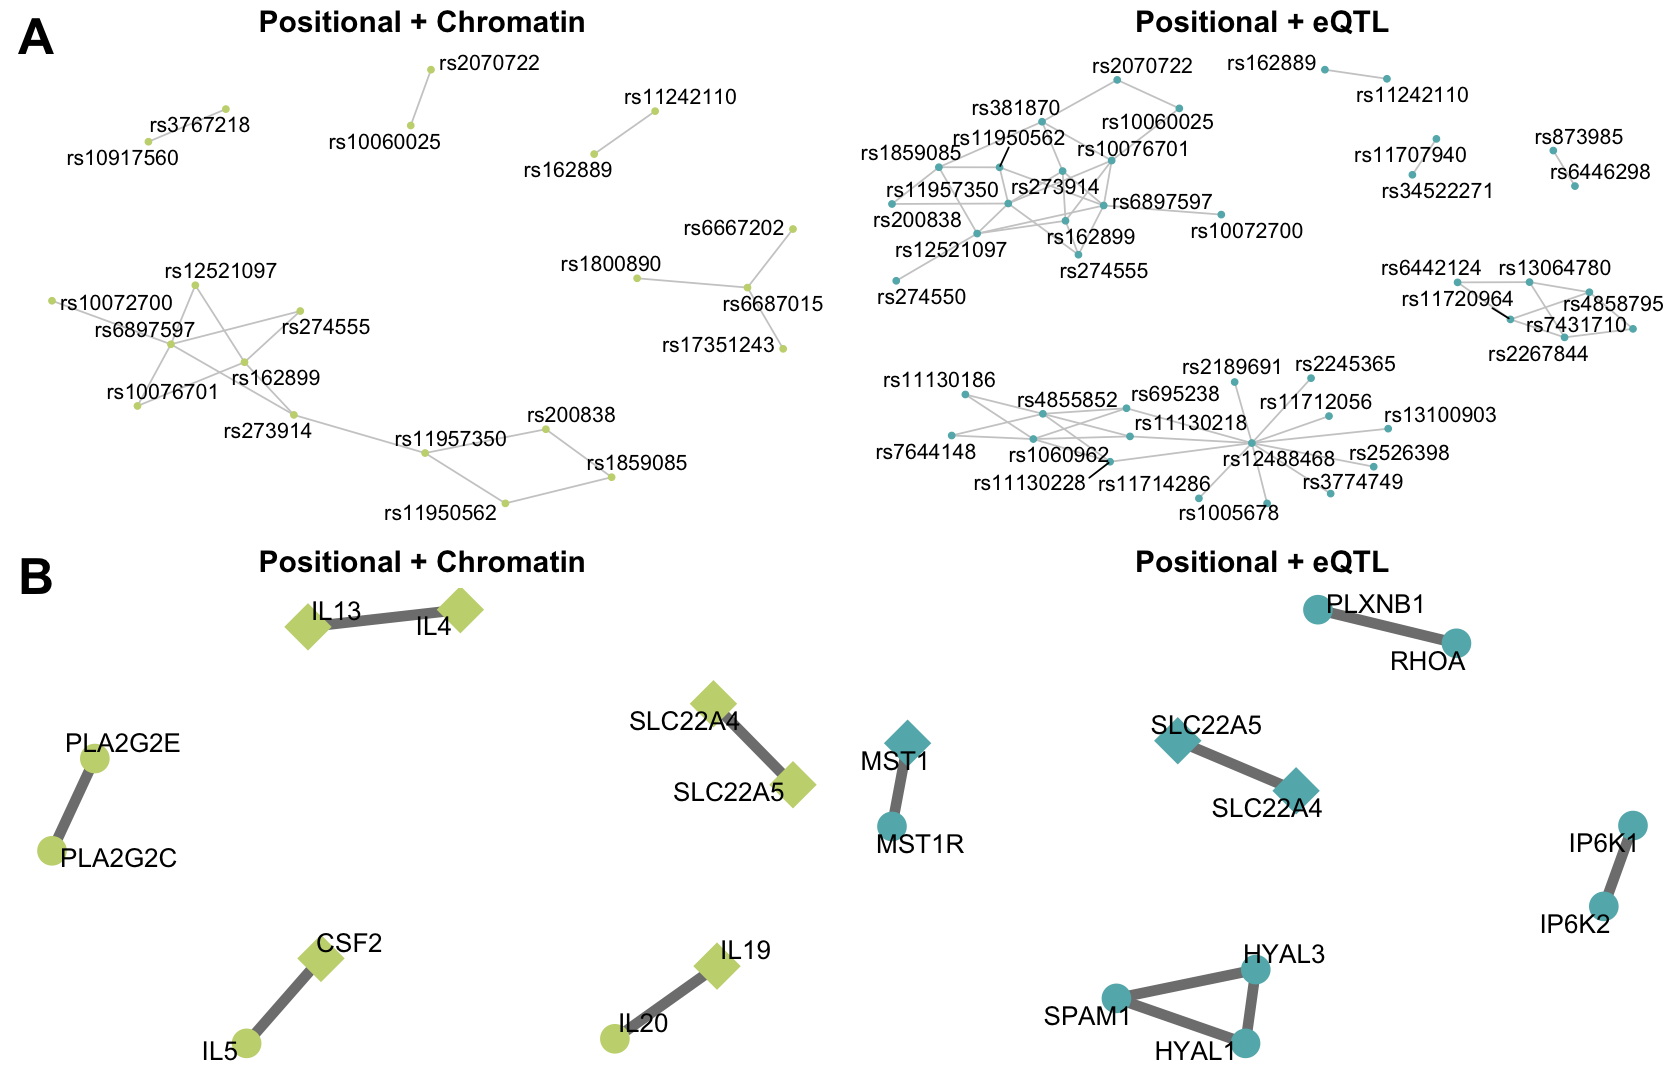

In [14]:
options(repr.plot.width=14, repr.plot.height=9)
plot_grid(snp_plot, gene_plot, 
          nrow = 2, labels = c('A','B'), label_size = 30)

ggsave(filename = 'fig/supp_positional_networks.png', width=14, height=9, bg = "transparent")
ggsave(filename = 'fig/supp_positional_networks.pdf', width=14, height=9, bg = "transparent")